In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random 

import itertools


def loadData(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.csv', usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies

def visualizeData(ratings, movies):
    print('Ratings is a {} Frame'.format(ratings.shape))
    print(ratings.head())
    print('\n')
    print(ratings.describe())
    print('\n')
    print('Movies is a {} Frame'.format(movies.shape))
    print(movies.head())
    
    nUsers = len(ratings['userId'].unique())
    print("There are {} users in the dataset.".format(nUsers))
    nMovies = len(movies['movieId'].unique())
    print("There are {} movies in the dataset.".format(nMovies))
    
    ratings['rating'].hist(bins=50)
    
def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId', columns='movieId', values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R
    
class MatrixFactorization():
    """
        A Simple Matrix Factorization Class.
        Assumes ratings is a m x n Numpy Array. 
        nFactors is the intermediate dimension k of the Matrices U and V.
        lambdaReg and muReg are regularization parameters.
        Blabla..
    """
    def __init__(self, ratings, nFactors=10, lambdaReg=0.0, muReg=0.0, alpha=0.01, maxIter=100, epsilon=0.001, trainFrac=0.8, valFrac=0.1, testFrac=0.1):
        np.random.seed(0) #Fix seed
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.muReg = muReg
        self.nUsers, self.nMovies = ratings.shape
        self.alpha = alpha
        self.maxIter = maxIter
        self.U = np.random.normal(size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(size=(self.nMovies, self.nFactors))
        self.samples = self.matrix2Samples(ratings)
        self.epsilon = epsilon
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac
        
    def randomInit(self):
        self.U = np.random.normal(size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(size=(self.nMovies, self.nFactors))
        
    def matrix2Samples(self, R):
        samples = [(i, j, R[i,j]) for i in range(self.nUsers)
           for j in range(self.nMovies) if R[i,j] > 0]
        return samples
    
    def Samples2Matrix(self, samples, m, n):
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
        return matrix
    
    
    def splitTrainValTest(self):
        # Shuffle the samples and sends back a partition for training, validation and testing
        np.random.shuffle(self.samples)
        nSamples = len(self.samples)
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainSamples, valSamples, testSamples = self.samples[:e1], self.samples[e1:e2], self.samples[e2:]
        
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainSamples, valSamples, testSamples
    
    def trainValTestIdx(self):
        # Returns a partitions of indices 
        nSamples = len(self.samples)
        interval = range(nSamples)
        np.random.shuffle(interval)
        
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainIdx, valIdx, testIdx = interval[:e1], interval[e1:e2], interval[e2:]
        
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainIdx, valIdx, testIdx
    
    #def stochasticGradientDescentPass(self, R, U, V, alpha, lambdaReg, muReg, nFactors):
    #    for i in range(R.shape[0]):
    #        for j in range(R.shape[1]):
    #            if R[i, j] > 0:
    #                r_hat_ij = np.dot(U[i, :], V.T[:, j])
    #                eij = R[i, j] - r_hat_ij
    #                for q in range(nFactors):
    #                    U[i, q] = U[i, q] + alpha * (eij * V[j, q] - lambdaReg * U[i, q])
    #                    V[j, q] = V[j, q] + alpha * (eij * U[i, q] - muReg * V[j, q])
    #    return U, V

    def stochasticGradientDescentPass(self, trainSamples):
        for s in trainSamples:
            i, j, _ = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j])
            eij = self.R[i, j] - r_hat_ij
            tmpU = np.zeros(self.nFactors)
            tmpV = np.zeros(self.nFactors)
            for q in range(self.nFactors):
                tmpU[q] = self.U[i, q] + self.alpha * (eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
                tmpV[q] = self.V[j, q] + self.alpha * (eij * self.U[i, q] - self.muReg * self.V[j, q])
            
            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]
            
        return self.U, self.V

    def gridSearch(self, factors, alphas, lambdaRegs, muRegs):
        lowest_error = math.inf
        best_config = None
        bestSolution = (None, None)
        for config in itertools.product(factors, alphas, lambdaRegs, muRegs):
            self.nFactors, self.alpha, self.lambdaReg, self.muReg = config
            U, V, history = self.stochasticGradientDescent(False)
            if history['valError'] < lowest_error:
                lowest_error = history['valError']
                best_config = config
                bestSolution = (U, V)
                
        self.U, self.V = bestSolution    # Just for consistency 
        
        return U, V, best_config
            
            
    def stochasticGradientDescent(self, logging=True):
        history = {'trainErrors':[], 'valErrors':[]}
        self.randomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()  # This should probably be outside ?
        for i in range(self.maxIter):
            # I think we should shuffle the data here. 
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            trainError = self.computeTotalErrorSamples(trainSamples)
            
            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history


    def computeTotalErrorSamples(self, data):
        error = 0
        for s in data:
            i, j, _ = s
            error += (R[i, j] - np.dot(self.U[i, :], self.V.T[:, j])) ** 2
        return error / (len(data) + 1)

    def plotHistory(self, history): 
        plt.plot(history['trainErrors'], label='Training Error')
        plt.plot(history['valErrors'], label='Validation Error')
        plt.title('Evolution of the Loss')
        plt.ylabel('Loss Func')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        
    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)
    
    def alsIteration(self, R, fixedVectors, solveVectors, regParameter):
        A = np.dot(fixedVectors.T,
                   fixedVectors) + np.eye(self.nFactors) * regParameter
        b = np.dot(R, fixedVectors)
        A_inv = np.linalg.inv(A)
        solveVectors = b.dot(A_inv)
        return solveVectors

    def alsFit(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        for i in range(self.maxIter):
            np.random.shuffle(trainSamples)
            self.U = self.alsIteration(self.R, self.V, self.U, self.lambdaReg)
            self.V = self.alsIteration(self.R.T, self.U, self.V, self.muReg)
            trainError = self.computeTotalErrorSamples(trainSamples)

            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return self.U, self.V, history
    
# Generates a rank(k) matrix. Should add some noise..    
def syntheticMatrix(m, n, k):
    basis = np.random.randint(3, size=(m, k))
    matrix = np.zeros((m, n))
    coeffs = np.random.randint(4, size=k)
    
    for i in range(n):
        coeffs = np.random.randint(4, size=k)
        matrix[:, i] = sum([coeffs[j] * basis[:, j] for j in range(k)]) # TODO: + some small noise vector
         
    return matrix
    

Ratings is a (100836, 3) Frame
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


              userId        movieId         rating
count  100836.000000  100836.000000  100836.000000
mean      326.127564   19435.295718       3.501557
std       182.618491   35530.987199       1.042529
min         1.000000       1.000000       0.500000
25%       177.000000    1199.000000       3.000000
50%       325.000000    2991.000000       3.500000
75%       477.000000    8122.000000       4.000000
max       610.000000  193609.000000       5.000000


Movies is a (9742, 3) Frame
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

               

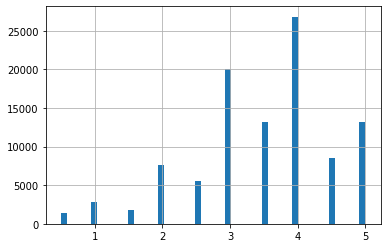

In [33]:
ratings, movies = loadData('Data/')
visualizeData(ratings, movies)

(1, 0.0001, 0.01, 0.01)


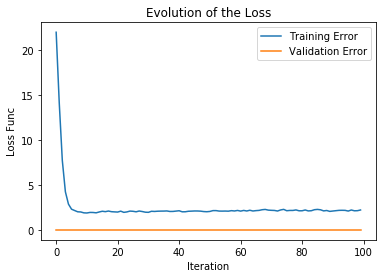

In [49]:
R = syntheticMatrix(20, 8, 3)

mf = MatrixFactorization(R, nFactors=3, lambdaReg=1.0, muReg=1.0, trainFrac=1.0, valFrac=0.0, testFrac=0.0)
U, V, best_config = mf.gridSearch(factors=[1, 3, 5, 10], alphas=[0.0001, 0.001, 0.01], lambdaRegs=[0.01, 0.1, 1.0], muRegs=[0.01, 0.1, 1.0])
print(best_config)
U, V, history = mf.stochasticGradientDescent(True)
mf.plotHistory(history)

In [54]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

In [65]:
mf = MatrixFactorization(R, nFactors=4, lambdaReg=0, muReg=0, alpha=0.005)

In [66]:
U, V, history = mf.stochasticGradientDescent(True)

In [67]:
np.dot(U, V.T)

array([[ 4.9550433 ,  2.98421292,  1.96209021, -4.50996717],
       [ 4.06011889,  0.29570291,  4.96896817,  1.10690957],
       [ 0.89377281,  1.04694326,  2.13071786,  4.78906724],
       [ 0.75436423,  1.34644882,  1.32348554,  4.11929258],
       [-1.18982096,  0.93475423,  0.61228333,  3.99111849]])

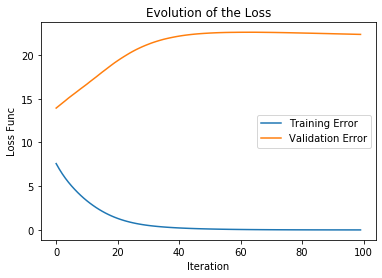

In [46]:
mf.plotHistory(history)